# Poetry Generation with LSTM 

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Embedding,Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K

In [68]:
MAX_SEQUENCE_LENGTH=100
MAX_VOCAB_SIZE=3000
EMBEDDING_DIM=50
VALIDATION_SPLIT=0.2
BATCH_SIZE=128
EPOCHS=2000
LATENT_DIM=25

In [69]:
# load in the data
input_texts = []
target_texts = []
for line in open('./large_files/robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue
    input_line = '<sos> ' + line
    target_line = line + ' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)

all_lines = input_texts+target_texts

In [70]:
for l in input_texts:
    if 'bulkhead' in l:
        print(l)

<sos> The bulkhead double-doors were double-locked


## Tokenization

In [71]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [72]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [73]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 3056 unique tokens.


## Padding

In [74]:
# pad sequences so that we get a N x T matrix
max_sequence_length = min(max_sequence_length_from_data,MAX_SEQUENCE_LENGTH)
input_sequences=pad_sequences(input_sequences,maxlen=max_sequence_length,padding='post')
target_sequences=pad_sequences(target_sequences,maxlen=max_sequence_length,padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


## Load word embedding

In [75]:
# load in pre-trained word vectors
word2vec ={}
with open('./large_files/glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word=values[0]
        vec = np.array(values[1:],dtype='float32')
        word2vec[word]=vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [76]:
# prepare embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[i]=embedding_vec

If you pass in the `sparse_categorical_crossentropy` loss function into Keras it won't work when each target is a sequence.

In [77]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences),max_sequence_length,num_words))
for i, target_sequence in enumerate(target_sequences):
    for t,word in enumerate(target_sequence):
        if word>0:
            one_hot_targets[i,t,word]=1
one_hot_targets.shape

(1436, 12, 3000)

## Build model

In [78]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            #trainable=False
                           )

For this model we have three inputs: 

In [79]:
# create an LSTM network with a single LSTM
input_=Input(shape=(max_sequence_length,))
# hidden state
intial_h = Input(shape=(LATENT_DIM,))
# cell state
intial_c = Input(shape=(LATENT_DIM,))

We want to pass in the hidden state and cell state because we want to have control over the initial states.

We're going to pass in the same states during prediction.

So we want there to be consistency once we have our inputs. 

In [80]:
x=embedding_layer(input_)

# return_sequences = True , because LSTM output must be a sequence since it has to predict the rest of the sentence.
lstm=LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_ = lstm(x,initial_state=[intial_h,intial_c])
dense = Dense(num_words,activation='softmax')
output=dense(x)

In [81]:
model=Model([input_,intial_h,intial_c],output)
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy'])
model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 12, 50)       150000      input_24[0][0]                   
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 25)]         0                                            
______________________________________________________________________________________

## Train the model

In [82]:
z=np.zeros((len(input_sequences), LATENT_DIM))

In [83]:
r = model.fit([input_sequences, z, z],
              one_hot_targets,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=VALIDATION_SPLIT)

Epoch 1/2000
9/9 [==============================] - 1s 98ms/step - loss: 5.3951 - accuracy: 0.0478 - val_loss: 5.0740 - val_accuracy: 0.0104
Epoch 2/2000
9/9 [==============================] - 1s 73ms/step - loss: 4.6433 - accuracy: 0.0558 - val_loss: 4.8233 - val_accuracy: 0.0833
Epoch 3/2000
9/9 [==============================] - 1s 73ms/step - loss: 4.3837 - accuracy: 0.0833 - val_loss: 4.9301 - val_accuracy: 0.0833
Epoch 4/2000
9/9 [==============================] - 1s 74ms/step - loss: 4.3291 - accuracy: 0.0833 - val_loss: 4.9373 - val_accuracy: 0.0833
Epoch 5/2000
9/9 [==============================] - 1s 73ms/step - loss: 4.2905 - accuracy: 0.0833 - val_loss: 4.9694 - val_accuracy: 0.0833
Epoch 6/2000
9/9 [==============================] - 1s 73ms/step - loss: 4.2526 - accuracy: 0.0833 - val_loss: 4.9461 - val_accuracy: 0.0833
Epoch 7/2000
9/9 [==============================] - 1s 74ms/step - loss: 4.2018 - accuracy: 0.0833 - val_loss: 4.9051 - val_accuracy: 0.0833
Epoch 8/2000


Epoch 59/2000
9/9 [==============================] - 1s 73ms/step - loss: 2.5331 - accuracy: 0.2286 - val_loss: 5.1919 - val_accuracy: 0.0938
Epoch 60/2000
9/9 [==============================] - 1s 74ms/step - loss: 2.5151 - accuracy: 0.2297 - val_loss: 5.2032 - val_accuracy: 0.0923
Epoch 61/2000
9/9 [==============================] - 1s 73ms/step - loss: 2.4961 - accuracy: 0.2339 - val_loss: 5.2138 - val_accuracy: 0.0929
Epoch 62/2000
9/9 [==============================] - 1s 73ms/step - loss: 2.4785 - accuracy: 0.2363 - val_loss: 5.2279 - val_accuracy: 0.0926
Epoch 63/2000
9/9 [==============================] - 1s 73ms/step - loss: 2.4603 - accuracy: 0.2369 - val_loss: 5.2353 - val_accuracy: 0.0935
Epoch 64/2000
9/9 [==============================] - 1s 74ms/step - loss: 2.4439 - accuracy: 0.2385 - val_loss: 5.2507 - val_accuracy: 0.0940
Epoch 65/2000
9/9 [==============================] - 1s 74ms/step - loss: 2.4263 - accuracy: 0.2409 - val_loss: 5.2608 - val_accuracy: 0.0929
Epoch 

9/9 [==============================] - 1s 74ms/step - loss: 1.8866 - accuracy: 0.3113 - val_loss: 5.7620 - val_accuracy: 0.0741
Epoch 117/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.8797 - accuracy: 0.3108 - val_loss: 5.7675 - val_accuracy: 0.0732
Epoch 118/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.8723 - accuracy: 0.3134 - val_loss: 5.7788 - val_accuracy: 0.0738
Epoch 119/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.8669 - accuracy: 0.3116 - val_loss: 5.7893 - val_accuracy: 0.0738
Epoch 120/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.8602 - accuracy: 0.3137 - val_loss: 5.7929 - val_accuracy: 0.0744
Epoch 121/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.8540 - accuracy: 0.3156 - val_loss: 5.8041 - val_accuracy: 0.0738
Epoch 122/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.8488 - accuracy: 0.3157 - val_loss: 5.8130 - val_accuracy: 0.0735
Epoch 123/2000

9/9 [==============================] - 1s 74ms/step - loss: 1.5548 - accuracy: 0.3659 - val_loss: 6.1730 - val_accuracy: 0.0663
Epoch 174/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.5497 - accuracy: 0.3660 - val_loss: 6.1922 - val_accuracy: 0.0642
Epoch 175/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.5446 - accuracy: 0.3645 - val_loss: 6.1887 - val_accuracy: 0.0660
Epoch 176/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.5400 - accuracy: 0.3689 - val_loss: 6.1866 - val_accuracy: 0.0680
Epoch 177/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.5359 - accuracy: 0.3670 - val_loss: 6.2087 - val_accuracy: 0.0634
Epoch 178/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.5312 - accuracy: 0.3665 - val_loss: 6.1828 - val_accuracy: 0.0689
Epoch 179/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.5274 - accuracy: 0.3696 - val_loss: 6.2128 - val_accuracy: 0.0648
Epoch 180/2000

9/9 [==============================] - 1s 73ms/step - loss: 1.3290 - accuracy: 0.4072 - val_loss: 6.5188 - val_accuracy: 0.0579
Epoch 231/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.3249 - accuracy: 0.4089 - val_loss: 6.5330 - val_accuracy: 0.0570
Epoch 232/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.3199 - accuracy: 0.4114 - val_loss: 6.5393 - val_accuracy: 0.0561
Epoch 233/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.3168 - accuracy: 0.4114 - val_loss: 6.5542 - val_accuracy: 0.0567
Epoch 234/2000
9/9 [==============================] - 1s 72ms/step - loss: 1.3140 - accuracy: 0.4111 - val_loss: 6.5452 - val_accuracy: 0.0561
Epoch 235/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.3111 - accuracy: 0.4111 - val_loss: 6.5696 - val_accuracy: 0.0567
Epoch 236/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.3082 - accuracy: 0.4113 - val_loss: 6.5677 - val_accuracy: 0.0573
Epoch 237/2000

9/9 [==============================] - 1s 74ms/step - loss: 1.1710 - accuracy: 0.4449 - val_loss: 6.8270 - val_accuracy: 0.0535
Epoch 288/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.1694 - accuracy: 0.4451 - val_loss: 6.8304 - val_accuracy: 0.0521
Epoch 289/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.1658 - accuracy: 0.4458 - val_loss: 6.8424 - val_accuracy: 0.0541
Epoch 290/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.1650 - accuracy: 0.4472 - val_loss: 6.8359 - val_accuracy: 0.0535
Epoch 291/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.1625 - accuracy: 0.4480 - val_loss: 6.8383 - val_accuracy: 0.0527
Epoch 292/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.1598 - accuracy: 0.4488 - val_loss: 6.8569 - val_accuracy: 0.0518
Epoch 293/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.1556 - accuracy: 0.4490 - val_loss: 6.8565 - val_accuracy: 0.0530
Epoch 294/2000

9/9 [==============================] - 1s 73ms/step - loss: 1.0606 - accuracy: 0.4723 - val_loss: 7.0773 - val_accuracy: 0.0524
Epoch 345/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.0578 - accuracy: 0.4711 - val_loss: 7.0815 - val_accuracy: 0.0524
Epoch 346/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.0561 - accuracy: 0.4721 - val_loss: 7.0812 - val_accuracy: 0.0527
Epoch 347/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.0536 - accuracy: 0.4729 - val_loss: 7.0969 - val_accuracy: 0.0530
Epoch 348/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.0487 - accuracy: 0.4754 - val_loss: 7.0916 - val_accuracy: 0.0503
Epoch 349/2000
9/9 [==============================] - 1s 74ms/step - loss: 1.0491 - accuracy: 0.4743 - val_loss: 7.1038 - val_accuracy: 0.0530
Epoch 350/2000
9/9 [==============================] - 1s 73ms/step - loss: 1.0478 - accuracy: 0.4741 - val_loss: 7.1037 - val_accuracy: 0.0541
Epoch 351/2000

9/9 [==============================] - 1s 74ms/step - loss: 0.9791 - accuracy: 0.4872 - val_loss: 7.3142 - val_accuracy: 0.0486
Epoch 402/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9783 - accuracy: 0.4906 - val_loss: 7.3145 - val_accuracy: 0.0489
Epoch 403/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.9788 - accuracy: 0.4904 - val_loss: 7.3054 - val_accuracy: 0.0503
Epoch 404/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.9757 - accuracy: 0.4901 - val_loss: 7.3203 - val_accuracy: 0.0480
Epoch 405/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9733 - accuracy: 0.4896 - val_loss: 7.3347 - val_accuracy: 0.0483
Epoch 406/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9743 - accuracy: 0.4901 - val_loss: 7.3275 - val_accuracy: 0.0489
Epoch 407/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9731 - accuracy: 0.4898 - val_loss: 7.3412 - val_accuracy: 0.0469
Epoch 408/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.9149 - accuracy: 0.5086 - val_loss: 7.4962 - val_accuracy: 0.0506
Epoch 459/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9129 - accuracy: 0.5060 - val_loss: 7.5002 - val_accuracy: 0.0498
Epoch 460/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9107 - accuracy: 0.5059 - val_loss: 7.4898 - val_accuracy: 0.0515
Epoch 461/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9091 - accuracy: 0.5076 - val_loss: 7.5179 - val_accuracy: 0.0486
Epoch 462/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9080 - accuracy: 0.5073 - val_loss: 7.5096 - val_accuracy: 0.0498
Epoch 463/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9097 - accuracy: 0.5073 - val_loss: 7.5166 - val_accuracy: 0.0498
Epoch 464/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.9066 - accuracy: 0.5064 - val_loss: 7.5094 - val_accuracy: 0.0512
Epoch 465/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.8613 - accuracy: 0.5151 - val_loss: 7.6828 - val_accuracy: 0.0515
Epoch 516/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8631 - accuracy: 0.5170 - val_loss: 7.6662 - val_accuracy: 0.0506
Epoch 517/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8614 - accuracy: 0.5173 - val_loss: 7.6820 - val_accuracy: 0.0503
Epoch 518/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8601 - accuracy: 0.5169 - val_loss: 7.6809 - val_accuracy: 0.0489
Epoch 519/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8595 - accuracy: 0.5186 - val_loss: 7.6974 - val_accuracy: 0.0503
Epoch 520/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8597 - accuracy: 0.5164 - val_loss: 7.6854 - val_accuracy: 0.0498
Epoch 521/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.8595 - accuracy: 0.5155 - val_loss: 7.7061 - val_accuracy: 0.0515
Epoch 522/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.8267 - accuracy: 0.5225 - val_loss: 7.8097 - val_accuracy: 0.0506
Epoch 573/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8278 - accuracy: 0.5210 - val_loss: 7.8202 - val_accuracy: 0.0486
Epoch 574/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8261 - accuracy: 0.5223 - val_loss: 7.8197 - val_accuracy: 0.0480
Epoch 575/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8244 - accuracy: 0.5224 - val_loss: 7.8230 - val_accuracy: 0.0492
Epoch 576/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.8245 - accuracy: 0.5237 - val_loss: 7.8184 - val_accuracy: 0.0486
Epoch 577/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8230 - accuracy: 0.5221 - val_loss: 7.8334 - val_accuracy: 0.0492
Epoch 578/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.8234 - accuracy: 0.5224 - val_loss: 7.8258 - val_accuracy: 0.0495
Epoch 579/2000

9/9 [==============================] - 1s 74ms/step - loss: 0.7945 - accuracy: 0.5290 - val_loss: 7.9301 - val_accuracy: 0.0506
Epoch 630/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7928 - accuracy: 0.5316 - val_loss: 7.9566 - val_accuracy: 0.0480
Epoch 631/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7921 - accuracy: 0.5315 - val_loss: 7.9343 - val_accuracy: 0.0489
Epoch 632/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7942 - accuracy: 0.5293 - val_loss: 7.9663 - val_accuracy: 0.0475
Epoch 633/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7957 - accuracy: 0.5281 - val_loss: 7.9531 - val_accuracy: 0.0477
Epoch 634/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7987 - accuracy: 0.5282 - val_loss: 7.9482 - val_accuracy: 0.0492
Epoch 635/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7943 - accuracy: 0.5281 - val_loss: 7.9486 - val_accuracy: 0.0469
Epoch 636/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.8015 - accuracy: 0.5234 - val_loss: 8.0010 - val_accuracy: 0.0501
Epoch 687/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7983 - accuracy: 0.5253 - val_loss: 7.9959 - val_accuracy: 0.0509
Epoch 688/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7981 - accuracy: 0.5242 - val_loss: 8.0132 - val_accuracy: 0.0486
Epoch 689/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7964 - accuracy: 0.5268 - val_loss: 7.9936 - val_accuracy: 0.0480
Epoch 690/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7969 - accuracy: 0.5260 - val_loss: 8.0108 - val_accuracy: 0.0466
Epoch 691/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7979 - accuracy: 0.5257 - val_loss: 8.0045 - val_accuracy: 0.0483
Epoch 692/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7922 - accuracy: 0.5274 - val_loss: 8.0069 - val_accuracy: 0.0477
Epoch 693/2000

9/9 [==============================] - 1s 74ms/step - loss: 0.7531 - accuracy: 0.5373 - val_loss: 8.0822 - val_accuracy: 0.0512
Epoch 744/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7536 - accuracy: 0.5379 - val_loss: 8.0805 - val_accuracy: 0.0515
Epoch 745/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7514 - accuracy: 0.5387 - val_loss: 8.0785 - val_accuracy: 0.0521
Epoch 746/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7510 - accuracy: 0.5391 - val_loss: 8.0903 - val_accuracy: 0.0498
Epoch 747/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7514 - accuracy: 0.5381 - val_loss: 8.0751 - val_accuracy: 0.0512
Epoch 748/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7509 - accuracy: 0.5375 - val_loss: 8.0869 - val_accuracy: 0.0527
Epoch 749/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7528 - accuracy: 0.5380 - val_loss: 8.0933 - val_accuracy: 0.0501
Epoch 750/2000

9/9 [==============================] - 1s 74ms/step - loss: 0.7544 - accuracy: 0.5354 - val_loss: 8.1471 - val_accuracy: 0.0524
Epoch 801/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7541 - accuracy: 0.5324 - val_loss: 8.1444 - val_accuracy: 0.0501
Epoch 802/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7529 - accuracy: 0.5369 - val_loss: 8.1480 - val_accuracy: 0.0512
Epoch 803/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7471 - accuracy: 0.5375 - val_loss: 8.1572 - val_accuracy: 0.0509
Epoch 804/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7462 - accuracy: 0.5364 - val_loss: 8.1507 - val_accuracy: 0.0503
Epoch 805/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7425 - accuracy: 0.5396 - val_loss: 8.1474 - val_accuracy: 0.0515
Epoch 806/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7424 - accuracy: 0.5394 - val_loss: 8.1517 - val_accuracy: 0.0503
Epoch 807/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.7269 - accuracy: 0.5420 - val_loss: 8.2739 - val_accuracy: 0.0466
Epoch 858/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7257 - accuracy: 0.5423 - val_loss: 8.2612 - val_accuracy: 0.0509
Epoch 859/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7244 - accuracy: 0.5421 - val_loss: 8.2597 - val_accuracy: 0.0498
Epoch 860/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7226 - accuracy: 0.5433 - val_loss: 8.2507 - val_accuracy: 0.0501
Epoch 861/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7245 - accuracy: 0.5422 - val_loss: 8.2872 - val_accuracy: 0.0477
Epoch 862/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7323 - accuracy: 0.5399 - val_loss: 8.2867 - val_accuracy: 0.0483
Epoch 863/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7333 - accuracy: 0.5404 - val_loss: 8.2854 - val_accuracy: 0.0472
Epoch 864/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.7260 - accuracy: 0.5412 - val_loss: 8.3010 - val_accuracy: 0.0489
Epoch 915/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7242 - accuracy: 0.5416 - val_loss: 8.3217 - val_accuracy: 0.0477
Epoch 916/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7219 - accuracy: 0.5417 - val_loss: 8.2975 - val_accuracy: 0.0498
Epoch 917/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7186 - accuracy: 0.5435 - val_loss: 8.3279 - val_accuracy: 0.0472
Epoch 918/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7164 - accuracy: 0.5442 - val_loss: 8.3123 - val_accuracy: 0.0472
Epoch 919/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7178 - accuracy: 0.5445 - val_loss: 8.3104 - val_accuracy: 0.0489
Epoch 920/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7152 - accuracy: 0.5443 - val_loss: 8.3079 - val_accuracy: 0.0477
Epoch 921/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.7011 - accuracy: 0.5464 - val_loss: 8.3533 - val_accuracy: 0.0486
Epoch 972/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7030 - accuracy: 0.5476 - val_loss: 8.3284 - val_accuracy: 0.0492
Epoch 973/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7010 - accuracy: 0.5478 - val_loss: 8.3412 - val_accuracy: 0.0483
Epoch 974/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7002 - accuracy: 0.5465 - val_loss: 8.3353 - val_accuracy: 0.0498
Epoch 975/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7023 - accuracy: 0.5473 - val_loss: 8.3283 - val_accuracy: 0.0483
Epoch 976/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7045 - accuracy: 0.5468 - val_loss: 8.3317 - val_accuracy: 0.0469
Epoch 977/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7037 - accuracy: 0.5464 - val_loss: 8.3248 - val_accuracy: 0.0483
Epoch 978/2000

9/9 [==============================] - 1s 73ms/step - loss: 0.7383 - accuracy: 0.5348 - val_loss: 8.3894 - val_accuracy: 0.0472
Epoch 1029/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7318 - accuracy: 0.5391 - val_loss: 8.3747 - val_accuracy: 0.0477
Epoch 1030/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7245 - accuracy: 0.5383 - val_loss: 8.3686 - val_accuracy: 0.0483
Epoch 1031/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7180 - accuracy: 0.5409 - val_loss: 8.3766 - val_accuracy: 0.0460
Epoch 1032/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7125 - accuracy: 0.5444 - val_loss: 8.3728 - val_accuracy: 0.0480
Epoch 1033/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.7104 - accuracy: 0.5436 - val_loss: 8.3841 - val_accuracy: 0.0460
Epoch 1034/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7084 - accuracy: 0.5446 - val_loss: 8.3813 - val_accuracy: 0.0457
Epoch 10

9/9 [==============================] - 1s 73ms/step - loss: 0.7068 - accuracy: 0.5452 - val_loss: 8.4345 - val_accuracy: 0.0460
Epoch 1086/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.7050 - accuracy: 0.5438 - val_loss: 8.4183 - val_accuracy: 0.0457
Epoch 1087/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6997 - accuracy: 0.5467 - val_loss: 8.4375 - val_accuracy: 0.0448
Epoch 1088/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6996 - accuracy: 0.5451 - val_loss: 8.4272 - val_accuracy: 0.0446
Epoch 1089/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6984 - accuracy: 0.5465 - val_loss: 8.4427 - val_accuracy: 0.0457
Epoch 1090/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6994 - accuracy: 0.5465 - val_loss: 8.4405 - val_accuracy: 0.0446
Epoch 1091/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6969 - accuracy: 0.5464 - val_loss: 8.4518 - val_accuracy: 0.0460
Epoch 10

9/9 [==============================] - 1s 73ms/step - loss: 0.6949 - accuracy: 0.5470 - val_loss: 8.4985 - val_accuracy: 0.0446
Epoch 1143/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6932 - accuracy: 0.5460 - val_loss: 8.5078 - val_accuracy: 0.0422
Epoch 1144/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6956 - accuracy: 0.5425 - val_loss: 8.4913 - val_accuracy: 0.0440
Epoch 1145/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6994 - accuracy: 0.5446 - val_loss: 8.4893 - val_accuracy: 0.0443
Epoch 1146/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6987 - accuracy: 0.5445 - val_loss: 8.4972 - val_accuracy: 0.0414
Epoch 1147/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6972 - accuracy: 0.5444 - val_loss: 8.4895 - val_accuracy: 0.0446
Epoch 1148/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6993 - accuracy: 0.5443 - val_loss: 8.4943 - val_accuracy: 0.0466
Epoch 11

9/9 [==============================] - 1s 73ms/step - loss: 0.6807 - accuracy: 0.5489 - val_loss: 8.5099 - val_accuracy: 0.0469
Epoch 1200/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6786 - accuracy: 0.5500 - val_loss: 8.5162 - val_accuracy: 0.0472
Epoch 1201/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6758 - accuracy: 0.5518 - val_loss: 8.4999 - val_accuracy: 0.0472
Epoch 1202/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6736 - accuracy: 0.5512 - val_loss: 8.4990 - val_accuracy: 0.0480
Epoch 1203/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6718 - accuracy: 0.5519 - val_loss: 8.5058 - val_accuracy: 0.0486
Epoch 1204/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6708 - accuracy: 0.5507 - val_loss: 8.5047 - val_accuracy: 0.0483
Epoch 1205/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6700 - accuracy: 0.5514 - val_loss: 8.5080 - val_accuracy: 0.0483
Epoch 12

9/9 [==============================] - 1s 73ms/step - loss: 0.6842 - accuracy: 0.5486 - val_loss: 8.5062 - val_accuracy: 0.0509
Epoch 1257/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6866 - accuracy: 0.5475 - val_loss: 8.5307 - val_accuracy: 0.0469
Epoch 1258/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6943 - accuracy: 0.5457 - val_loss: 8.5519 - val_accuracy: 0.0457
Epoch 1259/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6930 - accuracy: 0.5465 - val_loss: 8.5228 - val_accuracy: 0.0492
Epoch 1260/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6886 - accuracy: 0.5484 - val_loss: 8.5417 - val_accuracy: 0.0463
Epoch 1261/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6896 - accuracy: 0.5456 - val_loss: 8.5487 - val_accuracy: 0.0460
Epoch 1262/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6926 - accuracy: 0.5449 - val_loss: 8.5362 - val_accuracy: 0.0460
Epoch 12

9/9 [==============================] - 1s 74ms/step - loss: 0.6657 - accuracy: 0.5520 - val_loss: 8.5668 - val_accuracy: 0.0483
Epoch 1314/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6652 - accuracy: 0.5524 - val_loss: 8.5693 - val_accuracy: 0.0469
Epoch 1315/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6648 - accuracy: 0.5519 - val_loss: 8.5505 - val_accuracy: 0.0480
Epoch 1316/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6636 - accuracy: 0.5531 - val_loss: 8.5649 - val_accuracy: 0.0495
Epoch 1317/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6639 - accuracy: 0.5540 - val_loss: 8.5633 - val_accuracy: 0.0498
Epoch 1318/2000
9/9 [==============================] - 1s 73ms/step - loss: 0.6628 - accuracy: 0.5526 - val_loss: 8.5775 - val_accuracy: 0.0492
Epoch 1319/2000
9/9 [==============================] - 1s 74ms/step - loss: 0.6616 - accuracy: 0.5524 - val_loss: 8.5809 - val_accuracy: 0.0501
Epoch 13

9/9 [==============================] - 1s 78ms/step - loss: 0.6722 - accuracy: 0.5518 - val_loss: 8.6277 - val_accuracy: 0.0466
Epoch 1371/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6685 - accuracy: 0.5522 - val_loss: 8.6056 - val_accuracy: 0.0475
Epoch 1372/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6680 - accuracy: 0.5522 - val_loss: 8.6175 - val_accuracy: 0.0486
Epoch 1373/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6658 - accuracy: 0.5528 - val_loss: 8.6107 - val_accuracy: 0.0480
Epoch 1374/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6659 - accuracy: 0.5518 - val_loss: 8.6131 - val_accuracy: 0.0492
Epoch 1375/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6651 - accuracy: 0.5531 - val_loss: 8.6141 - val_accuracy: 0.0472
Epoch 1376/2000
9/9 [==============================] - 1s 78ms/step - loss: 0.6650 - accuracy: 0.5526 - val_loss: 8.6160 - val_accuracy: 0.0486
Epoch 13

Epoch 1427/2000
9/9 [==============================] - 1s 163ms/step - loss: 0.6690 - accuracy: 0.5510 - val_loss: 8.6366 - val_accuracy: 0.0480
Epoch 1428/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6706 - accuracy: 0.5499 - val_loss: 8.6228 - val_accuracy: 0.0477
Epoch 1429/2000
9/9 [==============================] - 1s 164ms/step - loss: 0.6745 - accuracy: 0.5486 - val_loss: 8.6359 - val_accuracy: 0.0477
Epoch 1430/2000
9/9 [==============================] - 1s 152ms/step - loss: 0.6723 - accuracy: 0.5481 - val_loss: 8.6501 - val_accuracy: 0.0486
Epoch 1431/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6704 - accuracy: 0.5500 - val_loss: 8.6356 - val_accuracy: 0.0475
Epoch 1432/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6698 - accuracy: 0.5506 - val_loss: 8.6272 - val_accuracy: 0.0483
Epoch 1433/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.6641 - accuracy: 0.5517 - val_loss: 8.6527 - val_ac

9/9 [==============================] - 1s 134ms/step - loss: 0.7084 - accuracy: 0.5404 - val_loss: 8.6564 - val_accuracy: 0.0492
Epoch 1484/2000
9/9 [==============================] - 1s 125ms/step - loss: 0.7094 - accuracy: 0.5385 - val_loss: 8.6681 - val_accuracy: 0.0469
Epoch 1485/2000
9/9 [==============================] - 1s 142ms/step - loss: 0.7180 - accuracy: 0.5355 - val_loss: 8.6253 - val_accuracy: 0.0509
Epoch 1486/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.7147 - accuracy: 0.5377 - val_loss: 8.6646 - val_accuracy: 0.0489
Epoch 1487/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.7072 - accuracy: 0.5389 - val_loss: 8.6679 - val_accuracy: 0.0489
Epoch 1488/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.7116 - accuracy: 0.5382 - val_loss: 8.6311 - val_accuracy: 0.0486
Epoch 1489/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.7037 - accuracy: 0.5404 - val_loss: 8.6475 - val_accuracy: 0.0469
E

9/9 [==============================] - 1s 158ms/step - loss: 0.6592 - accuracy: 0.5531 - val_loss: 8.6744 - val_accuracy: 0.0472
Epoch 1540/2000
9/9 [==============================] - 1s 161ms/step - loss: 0.6565 - accuracy: 0.5531 - val_loss: 8.6911 - val_accuracy: 0.0489
Epoch 1541/2000
9/9 [==============================] - 1s 157ms/step - loss: 0.6544 - accuracy: 0.5552 - val_loss: 8.6727 - val_accuracy: 0.0480
Epoch 1542/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6533 - accuracy: 0.5548 - val_loss: 8.6821 - val_accuracy: 0.0483
Epoch 1543/2000
9/9 [==============================] - 1s 151ms/step - loss: 0.6515 - accuracy: 0.5547 - val_loss: 8.6863 - val_accuracy: 0.0480
Epoch 1544/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6503 - accuracy: 0.5549 - val_loss: 8.6888 - val_accuracy: 0.0477
Epoch 1545/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.6505 - accuracy: 0.5550 - val_loss: 8.6892 - val_accuracy: 0.0480
E

9/9 [==============================] - 1s 155ms/step - loss: 0.6483 - accuracy: 0.5550 - val_loss: 8.6875 - val_accuracy: 0.0486
Epoch 1596/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.6477 - accuracy: 0.5542 - val_loss: 8.6977 - val_accuracy: 0.0477
Epoch 1597/2000
9/9 [==============================] - 1s 164ms/step - loss: 0.6470 - accuracy: 0.5545 - val_loss: 8.6816 - val_accuracy: 0.0506
Epoch 1598/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6463 - accuracy: 0.5557 - val_loss: 8.6832 - val_accuracy: 0.0492
Epoch 1599/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6464 - accuracy: 0.5550 - val_loss: 8.6946 - val_accuracy: 0.0489
Epoch 1600/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.6453 - accuracy: 0.5547 - val_loss: 8.6861 - val_accuracy: 0.0503
Epoch 1601/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6438 - accuracy: 0.5565 - val_loss: 8.6880 - val_accuracy: 0.0498
E

9/9 [==============================] - 1s 155ms/step - loss: 0.6655 - accuracy: 0.5505 - val_loss: 8.6786 - val_accuracy: 0.0492
Epoch 1652/2000
9/9 [==============================] - 2s 167ms/step - loss: 0.6659 - accuracy: 0.5500 - val_loss: 8.6808 - val_accuracy: 0.0492
Epoch 1653/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.6639 - accuracy: 0.5516 - val_loss: 8.6813 - val_accuracy: 0.0486
Epoch 1654/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6588 - accuracy: 0.5530 - val_loss: 8.6786 - val_accuracy: 0.0503
Epoch 1655/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6572 - accuracy: 0.5537 - val_loss: 8.6805 - val_accuracy: 0.0483
Epoch 1656/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6546 - accuracy: 0.5538 - val_loss: 8.6817 - val_accuracy: 0.0512
Epoch 1657/2000
9/9 [==============================] - 1s 163ms/step - loss: 0.6531 - accuracy: 0.5539 - val_loss: 8.6915 - val_accuracy: 0.0503
E

9/9 [==============================] - 1s 155ms/step - loss: 0.6835 - accuracy: 0.5444 - val_loss: 8.6927 - val_accuracy: 0.0503
Epoch 1708/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6851 - accuracy: 0.5441 - val_loss: 8.7283 - val_accuracy: 0.0480
Epoch 1709/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.6884 - accuracy: 0.5437 - val_loss: 8.7331 - val_accuracy: 0.0475
Epoch 1710/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6988 - accuracy: 0.5433 - val_loss: 8.7069 - val_accuracy: 0.0512
Epoch 1711/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.7076 - accuracy: 0.5430 - val_loss: 8.7121 - val_accuracy: 0.0501
Epoch 1712/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.7106 - accuracy: 0.5395 - val_loss: 8.7288 - val_accuracy: 0.0498
Epoch 1713/2000
9/9 [==============================] - 1s 162ms/step - loss: 0.7503 - accuracy: 0.5314 - val_loss: 8.7051 - val_accuracy: 0.0492
E

9/9 [==============================] - 1s 152ms/step - loss: 0.6397 - accuracy: 0.5558 - val_loss: 8.7616 - val_accuracy: 0.0472
Epoch 1764/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6397 - accuracy: 0.5560 - val_loss: 8.7681 - val_accuracy: 0.0477
Epoch 1765/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6393 - accuracy: 0.5554 - val_loss: 8.7633 - val_accuracy: 0.0489
Epoch 1766/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6390 - accuracy: 0.5561 - val_loss: 8.7572 - val_accuracy: 0.0480
Epoch 1767/2000
9/9 [==============================] - 1s 166ms/step - loss: 0.6400 - accuracy: 0.5557 - val_loss: 8.7600 - val_accuracy: 0.0483
Epoch 1768/2000
9/9 [==============================] - 1s 152ms/step - loss: 0.6395 - accuracy: 0.5565 - val_loss: 8.7570 - val_accuracy: 0.0486
Epoch 1769/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6396 - accuracy: 0.5543 - val_loss: 8.7628 - val_accuracy: 0.0489
E

9/9 [==============================] - 1s 157ms/step - loss: 0.6429 - accuracy: 0.5549 - val_loss: 8.7577 - val_accuracy: 0.0460
Epoch 1820/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.6420 - accuracy: 0.5547 - val_loss: 8.7619 - val_accuracy: 0.0466
Epoch 1821/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.6417 - accuracy: 0.5547 - val_loss: 8.7438 - val_accuracy: 0.0469
Epoch 1822/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6401 - accuracy: 0.5561 - val_loss: 8.7629 - val_accuracy: 0.0472
Epoch 1823/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.6411 - accuracy: 0.5557 - val_loss: 8.7705 - val_accuracy: 0.0457
Epoch 1824/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6408 - accuracy: 0.5558 - val_loss: 8.7645 - val_accuracy: 0.0480
Epoch 1825/2000
9/9 [==============================] - 1s 157ms/step - loss: 0.6403 - accuracy: 0.5551 - val_loss: 8.7674 - val_accuracy: 0.0477
E

9/9 [==============================] - 1s 154ms/step - loss: 0.6621 - accuracy: 0.5505 - val_loss: 8.8121 - val_accuracy: 0.0451
Epoch 1876/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6599 - accuracy: 0.5505 - val_loss: 8.7944 - val_accuracy: 0.0457
Epoch 1877/2000
9/9 [==============================] - 1s 157ms/step - loss: 0.6719 - accuracy: 0.5481 - val_loss: 8.7974 - val_accuracy: 0.0460
Epoch 1878/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6776 - accuracy: 0.5462 - val_loss: 8.8237 - val_accuracy: 0.0457
Epoch 1879/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6832 - accuracy: 0.5465 - val_loss: 8.8185 - val_accuracy: 0.0448
Epoch 1880/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6908 - accuracy: 0.5444 - val_loss: 8.7801 - val_accuracy: 0.0477
Epoch 1881/2000
9/9 [==============================] - 1s 150ms/step - loss: 0.6863 - accuracy: 0.5446 - val_loss: 8.7846 - val_accuracy: 0.0463
E

9/9 [==============================] - 1s 157ms/step - loss: 0.6441 - accuracy: 0.5550 - val_loss: 8.7534 - val_accuracy: 0.0509
Epoch 1932/2000
9/9 [==============================] - 1s 155ms/step - loss: 0.6450 - accuracy: 0.5557 - val_loss: 8.7441 - val_accuracy: 0.0509
Epoch 1933/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.6419 - accuracy: 0.5564 - val_loss: 8.7459 - val_accuracy: 0.0509
Epoch 1934/2000
9/9 [==============================] - 1s 156ms/step - loss: 0.6419 - accuracy: 0.5557 - val_loss: 8.7497 - val_accuracy: 0.0515
Epoch 1935/2000
9/9 [==============================] - 1s 154ms/step - loss: 0.6415 - accuracy: 0.5550 - val_loss: 8.7587 - val_accuracy: 0.0512
Epoch 1936/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6401 - accuracy: 0.5561 - val_loss: 8.7454 - val_accuracy: 0.0509
Epoch 1937/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6400 - accuracy: 0.5557 - val_loss: 8.7284 - val_accuracy: 0.0515
E

9/9 [==============================] - 1s 158ms/step - loss: 0.6819 - accuracy: 0.5455 - val_loss: 8.7484 - val_accuracy: 0.0498
Epoch 1988/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.6750 - accuracy: 0.5492 - val_loss: 8.7232 - val_accuracy: 0.0492
Epoch 1989/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.6748 - accuracy: 0.5495 - val_loss: 8.7539 - val_accuracy: 0.0492
Epoch 1990/2000
9/9 [==============================] - 2s 167ms/step - loss: 0.6693 - accuracy: 0.5510 - val_loss: 8.7431 - val_accuracy: 0.0524
Epoch 1991/2000
9/9 [==============================] - 1s 162ms/step - loss: 0.6658 - accuracy: 0.5518 - val_loss: 8.7470 - val_accuracy: 0.0506
Epoch 1992/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.6636 - accuracy: 0.5515 - val_loss: 8.7391 - val_accuracy: 0.0489
Epoch 1993/2000
9/9 [==============================] - 1s 158ms/step - loss: 0.6626 - accuracy: 0.5518 - val_loss: 8.7289 - val_accuracy: 0.0521
E

In [85]:
model.save('./model/poetry')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/poetry/assets


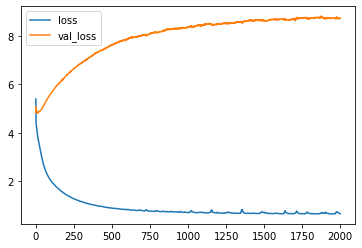

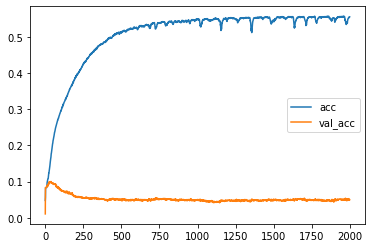

In [86]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Make a sampling model to predict

In [87]:
# For prediction the input size is different. We can only pass in one word at a time because we then have to use the 
# prediction as the next input.
input2=Input(shape=(1,))

# Importantly here's making use of the same layers defined earlier with the trained weights..
x = embedding_layer(input2)
# Remember that each step of the LSTM, calculation requires three inputs: The current word vector,
# the previous hidden state, and the previous cell state.
x,h,c = lstm(x,initial_state=[intial_h,intial_c])
output2=dense(x)

# sampling model will take in a single word index, a hidden state, and a cell state.
# It will output the next word probabilities, the next hidden state, and the next cell state.
sampling_model = Model([input2,intial_h,intial_c],[output2,h,c])

In [88]:
idx2word = {v:k for k,v in word2idx.items()}

In [89]:
def sample_line():
    # initial inputs
    np_input = np.array([[word2idx['<sos>']]])
    h=np.zeros((1,LATENT_DIM))
    c=np.zeros((1,LATENT_DIM))

    # so we know when to quit
    eos=word2idx['<eos>']

    # store the output here
    output_sentence=[]


    for _ in range(max_sequence_length):
        # O is a list of word probabilities for the next word. this is what we're going to take a sample from
        # H and C are the next hidden states and cell States.
        o,h,c = sampling_model.predict([np_input,h,c])
        probs = o[0,0]
        if np.argmax(probs)==0:
            print('warning')
        probs[0] = 0
        probs /= probs.sum()
        idx=np.random.choice(len(probs),p=probs)
        if idx ==eos:
            break
        output_sentence.append(idx2word.get(idx,'<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0]=idx
    return ' '.join(output_sentence)

In [90]:
# generate a 4 line poem
for _ in range(4):
    print(sample_line())

a brook that was was plagued so an old cedar and show
weep for what little things could make them glad.
that cased the world, and he was gone!
you can see what a lie


# Machine Translation with Seq2Seq

We have 1 regular LSTM for the **encoder** which takes in an input sentence and then our **decoder** 
produce the translation based on what the encoder gives us.

Training the **decoder** is going to be exactly like training  poetry generation model.

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [9]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

# load in the data
t=0
for line in open("./large_files/spa.txt"):
    t+=1
    if t>NUM_SAMPLES:
        break
    if '\t' not in line:
        continue
    input_text,translation,*rest = line.rstrip().split('\t')
    target_text = translation+' <eos>'
    target_text_input = '<sos> '+translation
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


## Tokenization

### Tokenize the inputs

In [10]:
## tokenize the inputs
tokenizer_input = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_input.fit_on_texts(input_texts)
input_sequences = tokenizer_input.texts_to_sequences(input_texts)

# explanation: 
# input_texts - english sentences
# input_sequences - vectors of integers
len(input_sequences),len(input_texts)

(10000, 10000)

In [11]:
# get the word to index mapping for input language
word2idx_input = tokenizer_input.word_index
print('Found %s unique input tokens.' % len(word2idx_input))

Found 2355 unique input tokens.


In [12]:
# determine maximum length input sequence
max_input_length=max(len(s) for s in input_sequences)
max_input_length

5

### Tokenize the outputs

In [13]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_target = Tokenizer(num_words=MAX_NUM_WORDS,filters='')
tokenizer_target.fit_on_texts(target_texts+target_texts_inputs)
target_sequences = tokenizer_target.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_target.texts_to_sequences(target_texts_inputs)

In [14]:
# get the word to index mapping for output language
word2idx_target = tokenizer_target.word_index
print('Found %s unique input tokens.' % len(word2idx_target))

Found 6326 unique input tokens.


In [15]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_target = len(word2idx_target)+1

# determine maximum length output sequence
max_target_length=max(len(s) for s in target_sequences)
max_target_length

9

## Pad the sequences

In [16]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences ,maxlen=max_input_length)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
decoder_inputs = pad_sequences(target_sequences_inputs,maxlen=max_target_length,padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
decoder_targets=pad_sequences(target_sequences,maxlen=max_target_length,padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 14]
decoder_inputs[0]: [   2 1462    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 9)


## Load pre-trained word vectors

In [17]:
# load in pre-trained word vectors
word2vec ={}
with open('./large_files/glove.6B/glove.6B.{}d.txt'.format(EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word=values[0]
        vec = np.array(values[1:],dtype='float32')
        word2vec[word]=vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [18]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_input)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_input.items():
    if i<MAX_NUM_WORDS:
        embedding_vec = word2vec.get(word)
        if embedding_vec is not None:
            embedding_matrix[i]=embedding_vec

In [19]:
# create embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix], 
                            input_length=max_input_length)

In [20]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences

# one-hot the targets (can't use sparse cross-entropy)
decoder_targets_one_hot = np.zeros((len(target_sequences),max_target_length,num_words_target))
for i, d in enumerate(decoder_targets):
    for t,word in enumerate(d):
        if word!=0:
            decoder_targets_one_hot[i,t,word]=1
decoder_targets_one_hot.shape

(10000, 9, 6327)

## Build the model

In [21]:
encoder_input_placeholder=Input(shape = (max_input_length,))
x=embedding_layer(encoder_input_placeholder)
encoder = LSTM(LATENT_DIM,return_state=True)

encoder_outputs,h,c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h,c]

In [22]:
# Set up the decoder, using [h, c] as initial state.
decoder_input_placeholder=Input(shape = (max_target_length,))
# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_target,EMBEDDING_DIM)
decoder_input_x = decoder_embedding(decoder_input_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(LATENT_DIM,
                    return_sequences=True,
                    return_state=True)

decoder_outputs,_,_=decoder_lstm(decoder_input_x,
                                 initial_state=encoder_states)

decoder_dense = Dense(num_words_target,activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [23]:
model = Model([encoder_input_placeholder,decoder_input_placeholder],
              decoder_outputs)

In [30]:
import keras.backend as K
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])




## Train the model

In [31]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [32]:
machines = tf.config.experimental.list_physical_devices()

In [33]:
tf.device(machines[-1])

In [34]:
# Place tensors on the CPU
r=model.fit([encoder_inputs,decoder_inputs],decoder_targets_one_hot,
         batch_size=BATCH_SIZE,
           epochs=EPOCHS,
           validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 9s 76ms/step - loss: 5.9816 - acc: 0.2763 - val_loss: 5.5082 - val_acc: 0.2689
Epoch 2/100
125/125 [==============================] - 9s 71ms/step - loss: 4.9495 - acc: 0.2988 - val_loss: 5.2562 - val_acc: 0.2887
Epoch 3/100
125/125 [==============================] - 9s 71ms/step - loss: 4.6065 - acc: 0.3172 - val_loss: 5.1019 - val_acc: 0.3045
Epoch 4/100
125/125 [==============================] - 9s 71ms/step - loss: 4.3046 - acc: 0.3394 - val_loss: 4.9860 - val_acc: 0.3243
Epoch 5/100
125/125 [==============================] - 9s 71ms/step - loss: 4.0282 - acc: 0.3635 - val_loss: 4.8602 - val_acc: 0.3521
Epoch 6/100
125/125 [==============================] - 9s 71ms/step - loss: 3.7825 - acc: 0.3946 - val_loss: 4.7891 - val_acc: 0.3679
Epoch 7/100
125/125 [==============================] - 9s 71ms/step - loss: 3.5526 - acc: 0.4201 - val_loss: 4.7416 - val_acc: 0.3785
Epoch 8/100
125/125 [==============================] - 9s 71ms

Epoch 62/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2365 - acc: 0.8873 - val_loss: 5.4577 - val_acc: 0.4298
Epoch 63/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2341 - acc: 0.8881 - val_loss: 5.4314 - val_acc: 0.4327
Epoch 64/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2328 - acc: 0.8875 - val_loss: 5.4511 - val_acc: 0.4303
Epoch 65/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2303 - acc: 0.8876 - val_loss: 5.4544 - val_acc: 0.4292
Epoch 66/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2279 - acc: 0.8884 - val_loss: 5.4672 - val_acc: 0.4299
Epoch 67/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2263 - acc: 0.8886 - val_loss: 5.5055 - val_acc: 0.4327
Epoch 68/100
125/125 [==============================] - 9s 71ms/step - loss: 0.2237 - acc: 0.8874 - val_loss: 5.5405 - val_acc: 0.4319
Epoch 69/100
125/125 [==============================] -

## Plot 

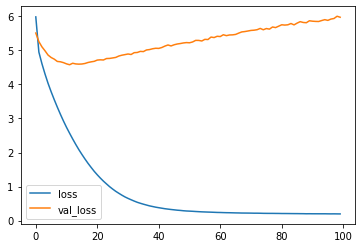

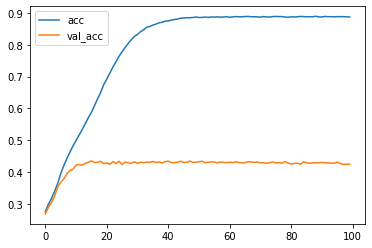

In [38]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## Make predictions

In [58]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# Create encoder model - takes in English sentences and return the final LSTM h&c
encoder_model = Model(encoder_input_placeholder,encoder_states)

In [59]:
# Create decoder model - use existing layers

# initial h & c for the LSTM
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

In [60]:
# a new input into the embedding
# shape = (1,) since we generate 1 word as a time
decoder_input_single = Input(shape=(1,))
decoder_input_single_x =decoder_embedding(decoder_input_single)


In [61]:
decoder_outputs,h,c = decoder_lstm(decoder_input_single_x,initial_state=decoder_state_inputs)
decoder_states=[h,c]
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model=Model([decoder_input_single]+decoder_state_inputs, [decoder_outputs]+decoder_states)

In [62]:
idx2word_eng={v:k for k, v in word2idx_input.items()}
idx2word_trans = {v:k for k,v in word2idx_target.items()}

In [63]:
# takes in an input sentence and generate a translation
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    state_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    # 1 sample and 1 timestamp
    target_seq= np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0,0]=word2idx_target.get('<sos>')

    # if we get this we break
    eos = word2idx_target.get('<eos>')

    # Create the translation
    output_translation =[]
    for _ in range(max_target_length):
        output_tokens,h,c = decoder_model.predict([target_seq]+state_value)

        # Get next word
        idx = np.argmax(output_tokens[0,0,:])
        if idx == eos:
            print(idx)
            break
        word = ''
        if idx>0:
            word = idx2word_trans[idx]
            output_translation.append(word)
        # Update the decoder input
        # which is just the word just generated
        target_seq[0,0] = idx

        # Update states
        state_value=[h,c]
    return ' '.join(output_translation)

In [66]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[i])
print('Translation:', translation)

1
-
Input: I love fish.
Translation: me encanta el pescado.
